In [ ]:
import os
import zipfile
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.resnet50 import preprocess_input
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/MyDrive/Datasets/kidney_refined_img'
csv_file_path = '/content/drive/MyDrive/Datasets/Coldsheet.csv'

extracted_files = os.listdir('/content/drive/MyDrive/Datasets/kidney_refined_img')

scores_df = pd.read_csv(csv_file_path)
scores_df.head()

Name of image  Score of 1 - 5
0  Cold Kidney 2               5
1  Cold Kidney 3               5
2  Cold Kidney 4               5
3  Cold Kidney 5               5
4  Cold Kidney 6               4

# **Data Preparation**

In [ ]:
def load_and_preprocess_image(image_path):
    if os.path.isfile(image_path):
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array
    return None

In [ ]:
image_dir = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new'
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, filename))]
image_arrays = [load_and_preprocess_image(path) for path in image_paths if load_and_preprocess_image(path) is not None]
image_arrays = np.vstack([img_array for img_array in image_arrays if img_array is not None])

In [ ]:
def format_filename(name):
    return os.path.splitext(name)[0].lower().strip()

In [ ]:
scores_df['formatted_name'] = scores_df['Name of image'].apply(format_filename)
# Map score according to images
name_to_score = dict(zip(scores_df['formatted_name'], scores_df['Score of 1 - 5']))

In [ ]:
# Cross the score with images and then create log file for those that is not matched
scores = []
not_found = []

for path in image_paths:
    if os.path.isfile(path):
        base_name = format_filename(os.path.basename(path))
        score = name_to_score.get(base_name, None)
        if score is not None:
            scores.append(score)
        else:
            not_found.append(os.path.basename(path))
            scores.append(-1)

if not_found:
    print("No scores found for the following files:")
    for file in not_found:
        print(file)
else:
    print("All files matched successfully.")

scores = np.array(scores)

All files matched successfully.


In [ ]:
valid_indices = [i for i, score in enumerate(scores) if score != -1]
image_arrays = image_arrays[valid_indices]
scores = np.array([scores[i] for i in valid_indices])

#**Resnet**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_arrays, scores, test_size=0.2, random_state=42)

y_train_one_hot = to_categorical(y_train - 1, num_classes=5)
y_test_one_hot = to_categorical(y_test - 1, num_classes=5)

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, shuffle = True)

Epoch 1/10
3/3 [==============================] - 23s 5s/step - loss: 64.2045 - accuracy: 0.3125
Epoch 2/10
3/3 [==============================] - 25s 8s/step - loss: 83.5039 - accuracy: 0.4875
Epoch 3/10
3/3 [==============================] - 20s 6s/step - loss: 35.8836 - accuracy: 0.7375
Epoch 4/10
3/3 [==============================] - 21s 6s/step - loss: 8.0325 - accuracy: 0.8625
Epoch 5/10
3/3 [==============================] - 19s 6s/step - loss: 2.8893 - accuracy: 0.9250
Epoch 6/10
3/3 [==============================] - 19s 5s/step - loss: 2.2967 - accuracy: 0.9375
Epoch 7/10
3/3 [==============================] - 21s 6s/step - loss: 0.5079 - accuracy: 0.9875
Epoch 8/10
3/3 [==============================] - 20s 7s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
3/3 [==============================] - 19s 5s/step - loss: 0.4340 - accuracy: 0.9875
Epoch 10/10
3/3 [==============================] - 20s 6s/step - loss: 0.0000e+00 - accuracy: 1.0000


In [ ]:
# predictions = MyModel.predict(X_test)
# predicted_scores = np.argmax(predictions, axis=1) + 1
# # Calculate accuracy and confusion matrix
# accuracy = accuracy_score(y_test, predicted_scores)
# conf_matrix = confusion_matrix(y_test, predicted_scores)
# print("Accuracy: {accuracy}")
# print("Confusion Matrix:\n{conf_matrix}")

In [ ]:
resnet_model = model.get_layer('resnet50')
# Print all layer names
for layer in resnet_model.layers:
    print(layer.name)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

1/1 [==============================] - 0s 131ms/step


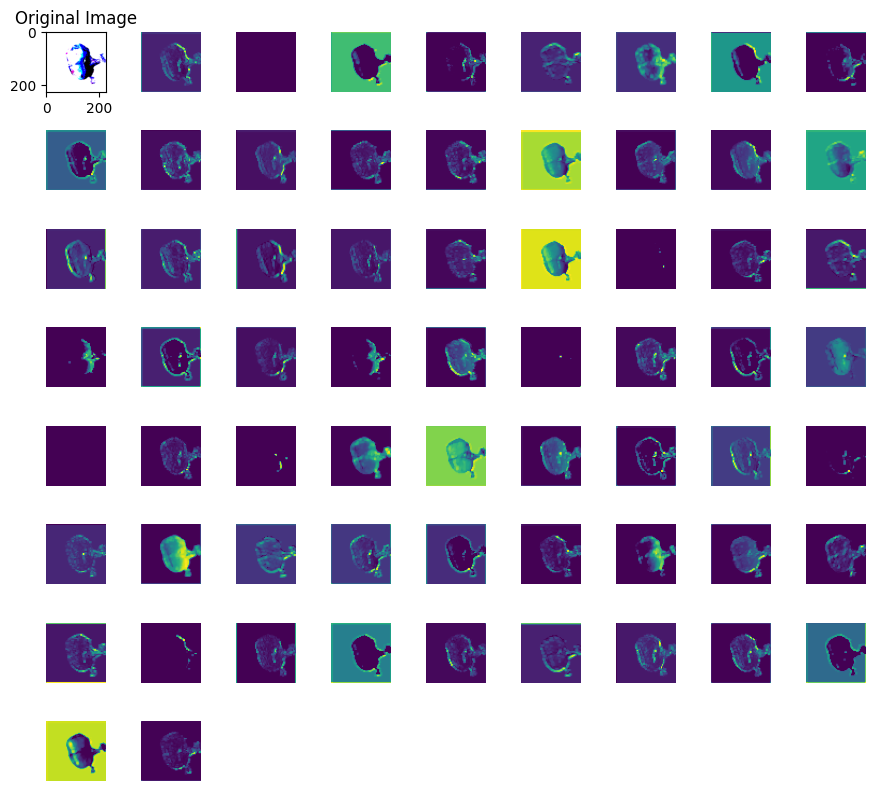

In [ ]:
# conv1_pad
# conv1_conv
# conv1_bn
# conv1_relu
# pool1_pad
# pool1_pool
layer_name = 'pool1_pool'
intermediate_layer_model = Model(inputs=resnet_model.input, outputs=resnet_model.get_layer(layer_name).output)

img_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
img = load_img(img_path, target_size=(224, 224))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

activations = intermediate_layer_model.predict(img_tensor)

# Number of features in the feature map
num_features = activations.shape[-1]

# Calculate the grid size needed to plot all feature maps and the original image
size = int(np.ceil(np.sqrt(num_features + 1)))  # +1 for the original image

# Plot original image
plt.figure(figsize=(size*1, size*1))
plt.subplot(size, size, 1)
plt.imshow(np.squeeze(img_tensor, axis=0))
plt.title('Original Image')

# Plot each channel in the feature map
for i in range(num_features):
    plt.subplot(size, size, i+2)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 315ms/step


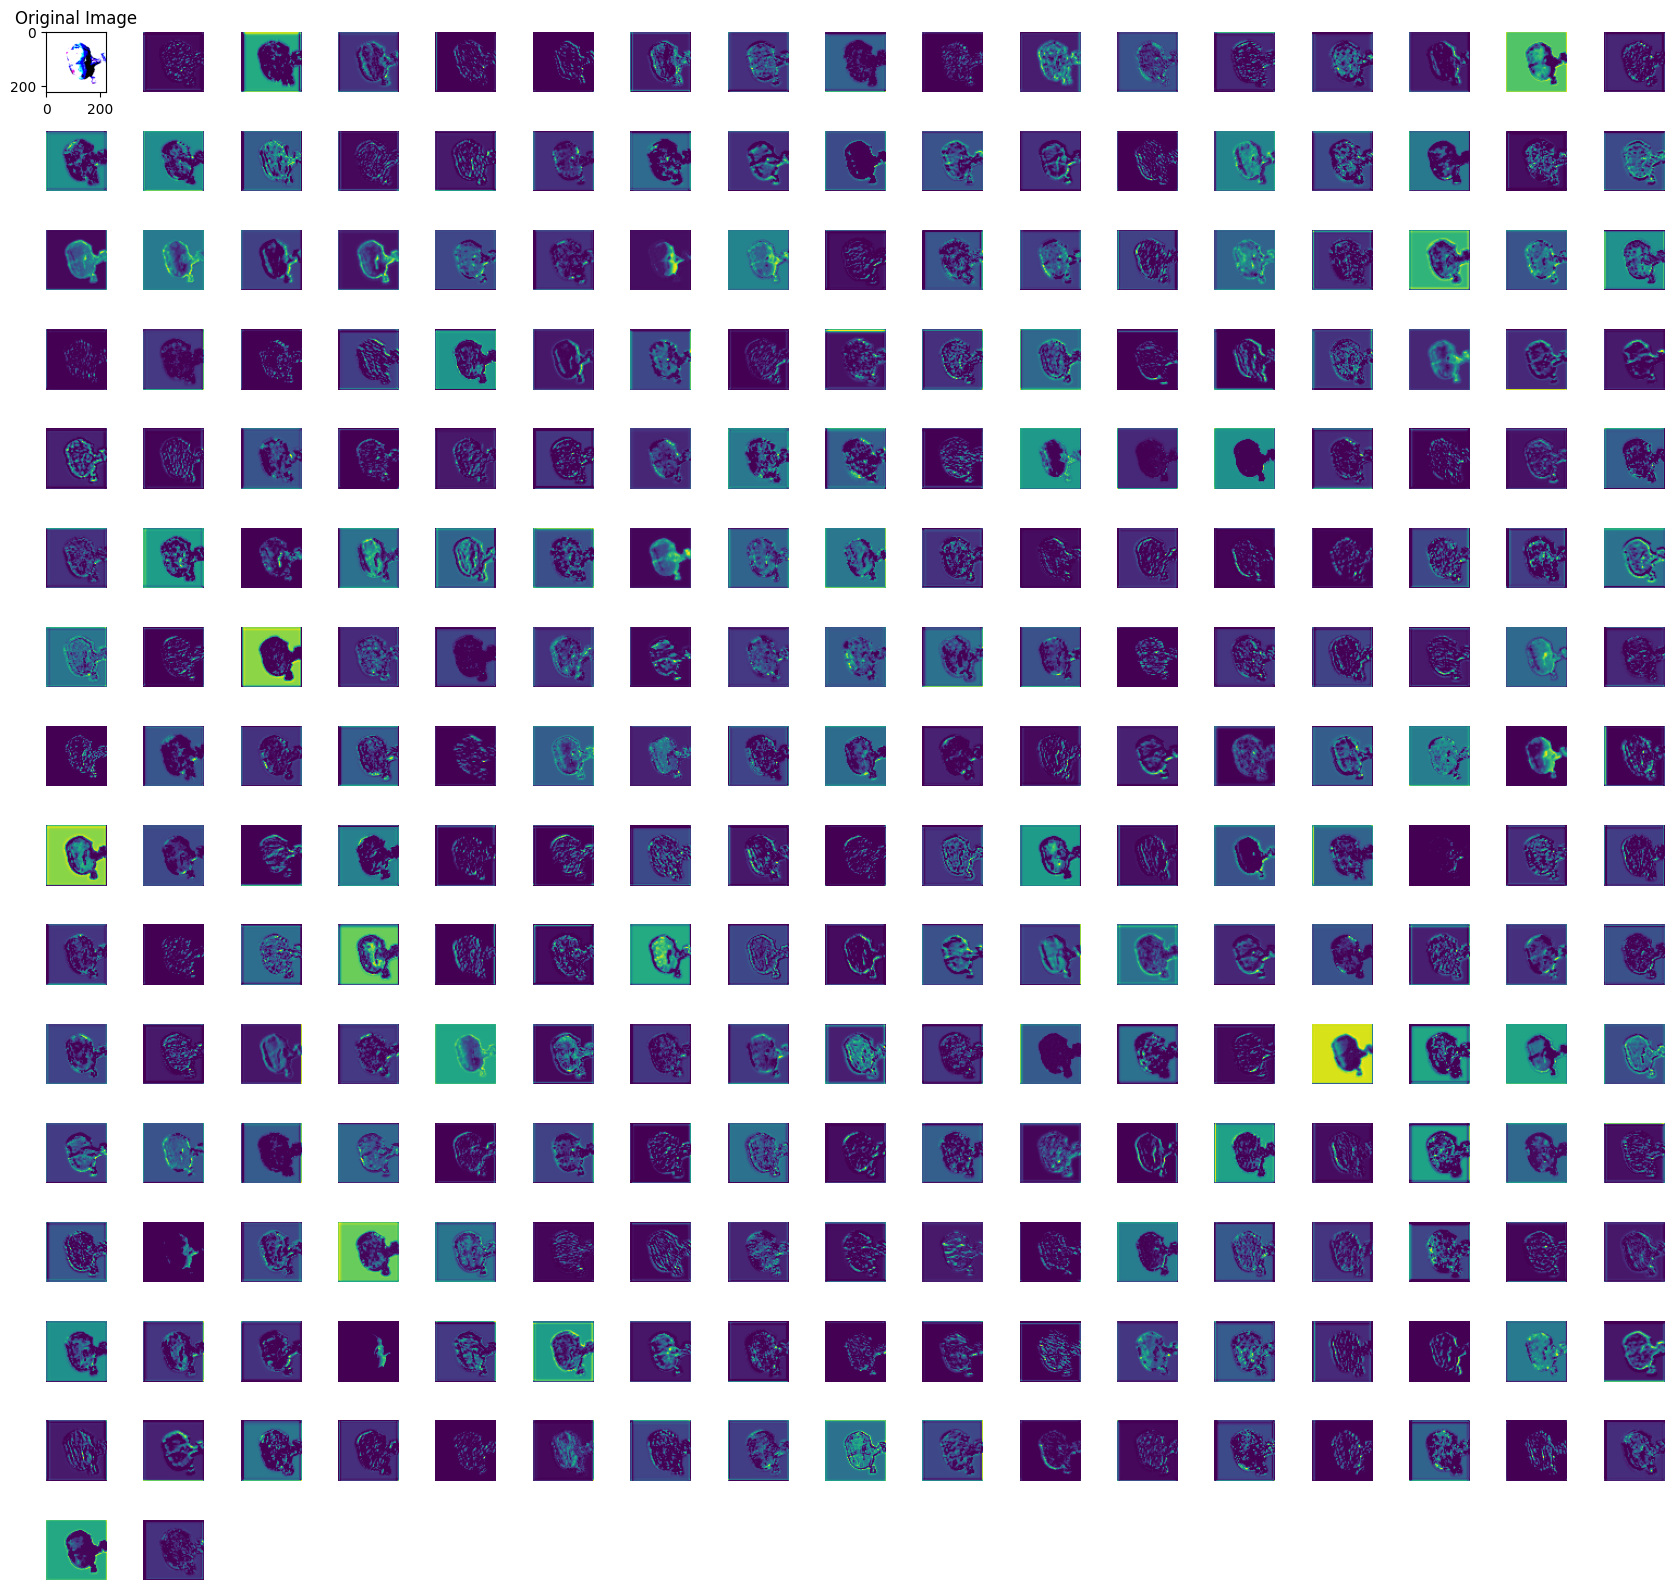

In [ ]:
layer_name = 'conv2_block3_out'
intermediate_layer_model = Model(inputs=resnet_model.input, outputs=resnet_model.get_layer(layer_name).output)

img_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
img = load_img(img_path, target_size=(224, 224))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

activations = intermediate_layer_model.predict(img_tensor)

# Number of features in the feature map
num_features = activations.shape[-1]

# Calculate the grid size needed to plot all feature maps and the original image
size = int(np.ceil(np.sqrt(num_features + 1)))  # +1 for the original image

# Plot original image
plt.figure(figsize=(size*1, size*1))
plt.subplot(size, size, 1)
plt.imshow(np.squeeze(img_tensor, axis=0))
plt.title('Original Image')

# Plot each channel in the feature map
for i in range(num_features):
    plt.subplot(size, size, i+2)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Original Image')

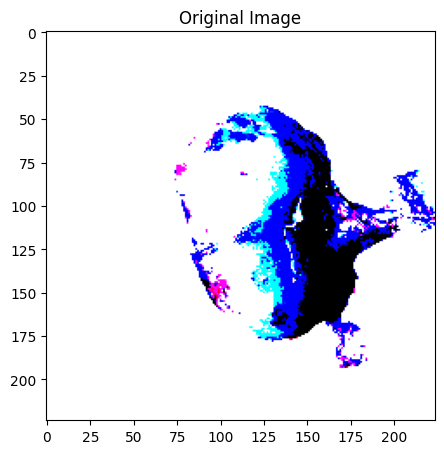

In [ ]:
plt.figure(figsize=(size*6, size*6))
plt.subplot(size, size, 1)
plt.imshow(np.squeeze(img_tensor, axis=0))
plt.title('Original Image')

1/1 [==============================] - 1s 575ms/step


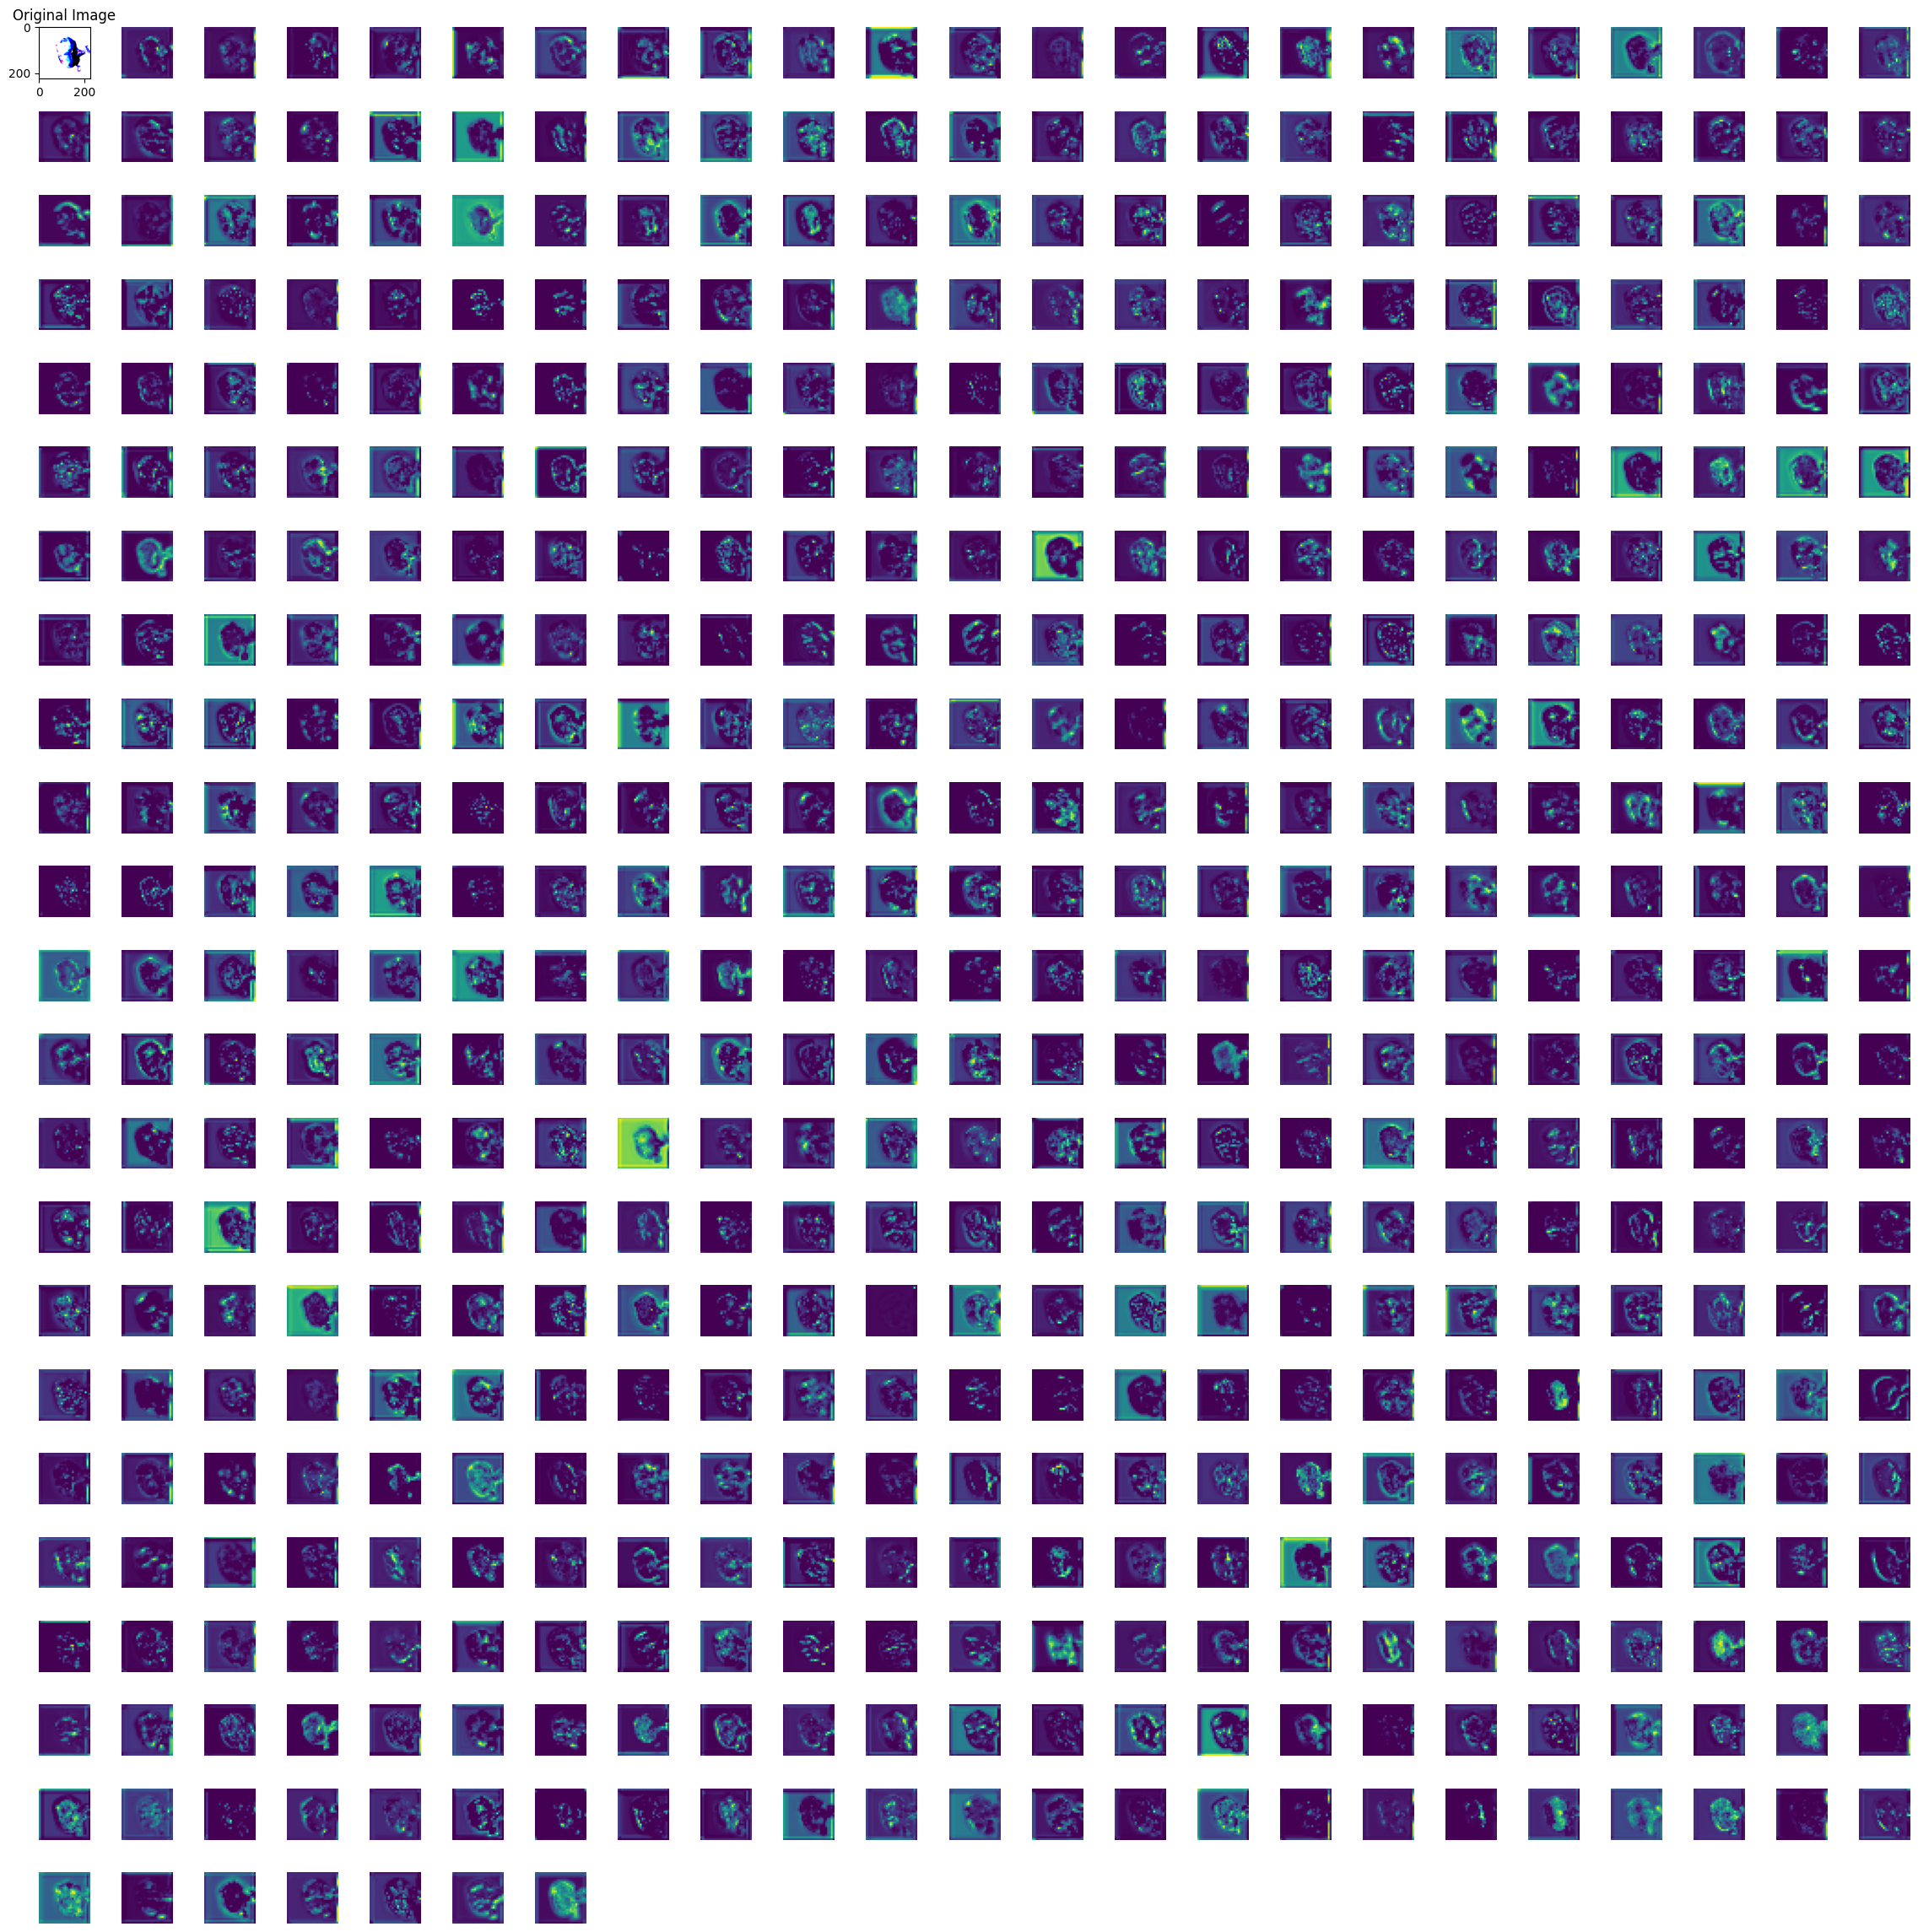

In [ ]:
layer_name = 'conv3_block4_out'
intermediate_layer_model = Model(inputs=resnet_model.input, outputs=resnet_model.get_layer(layer_name).output)

img_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
img = load_img(img_path, target_size=(224, 224))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

activations = intermediate_layer_model.predict(img_tensor)

# Number of features in the feature map
num_features = activations.shape[-1]

# Calculate the grid size needed to plot all feature maps and the original image
size = int(np.ceil(np.sqrt(num_features + 1)))  # +1 for the original image

# Plot original image
plt.figure(figsize=(size*1, size*1))
plt.subplot(size, size, 1)
plt.imshow(np.squeeze(img_tensor, axis=0))
plt.title('Original Image')

# Plot each channel in the feature map
for i in range(num_features):
    plt.subplot(size, size, i+2)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 1s/step


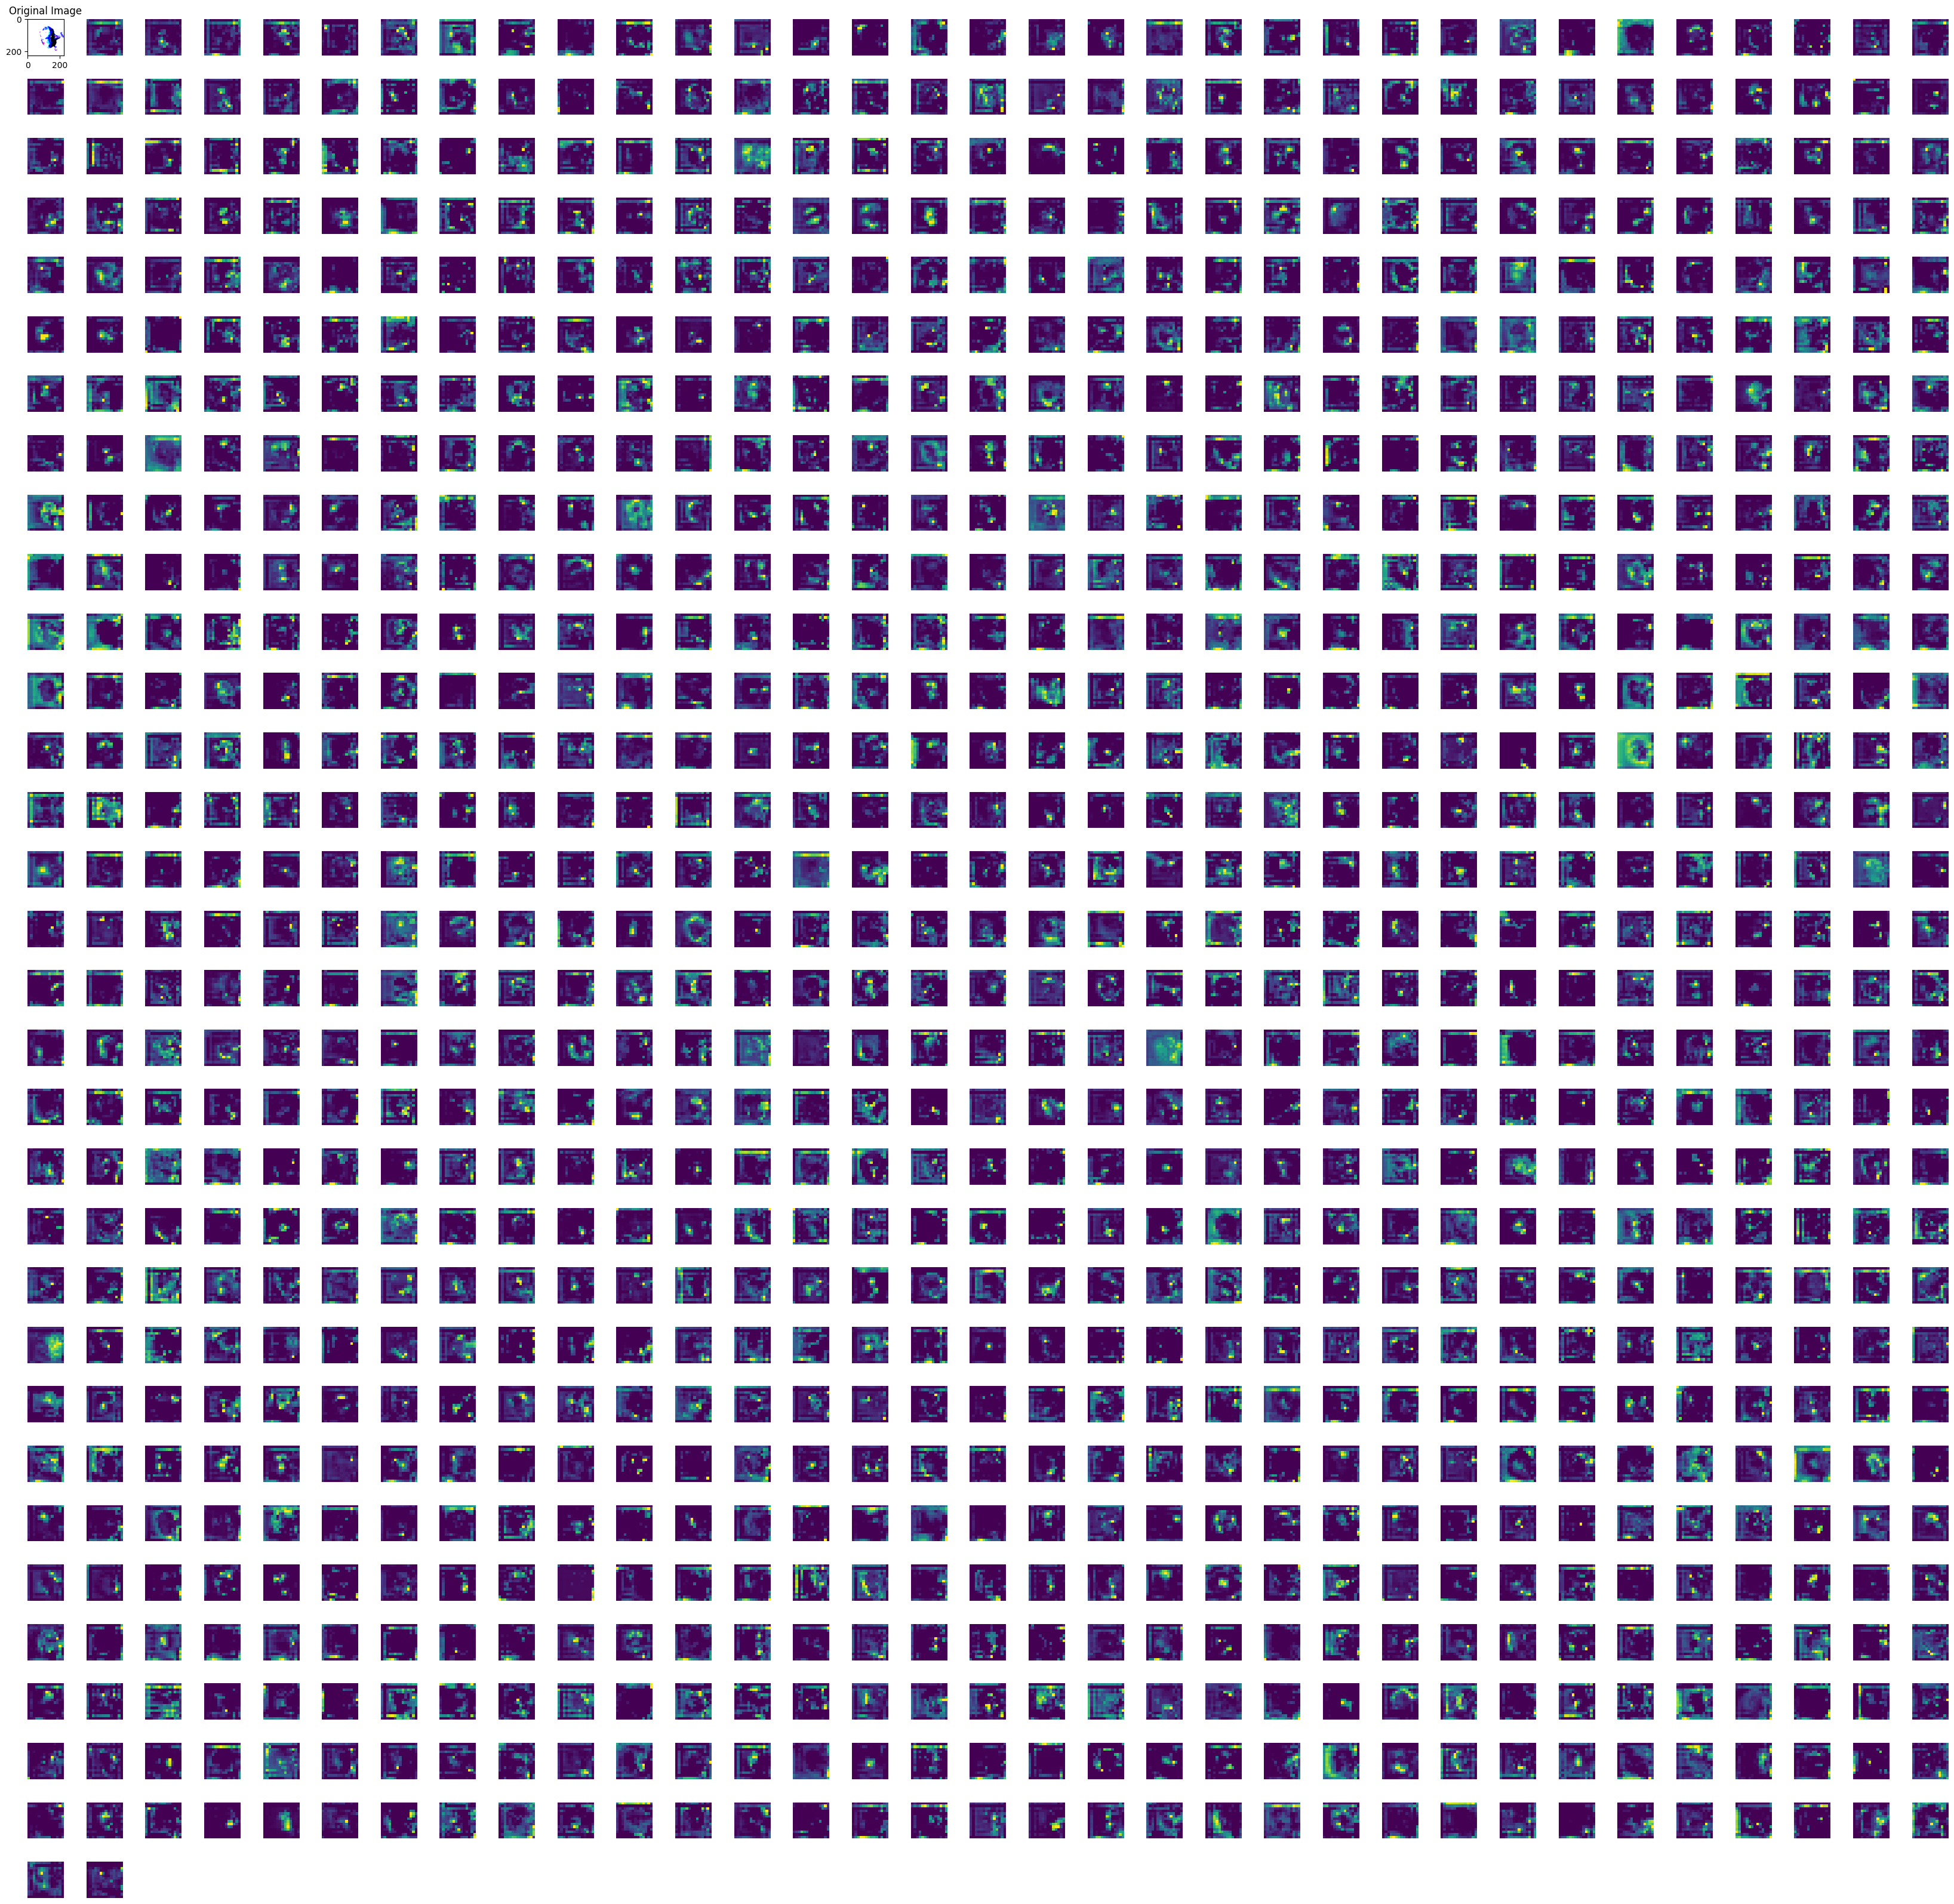

In [ ]:
layer_name = 'conv4_block6_out'
intermediate_layer_model = Model(inputs=resnet_model.input, outputs=resnet_model.get_layer(layer_name).output)

img_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
img = load_img(img_path, target_size=(224, 224))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

activations = intermediate_layer_model.predict(img_tensor)

# Number of features in the feature map
num_features = activations.shape[-1]

# Calculate the grid size needed to plot all feature maps and the original image
size = int(np.ceil(np.sqrt(num_features + 1)))  # +1 for the original image

# Plot original image
plt.figure(figsize=(size*1, size*1))
plt.subplot(size, size, 1)
plt.imshow(np.squeeze(img_tensor, axis=0))
plt.title('Original Image')

# Plot each channel in the feature map
for i in range(num_features):
    plt.subplot(size, size, i+2)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
layer_name = 'conv5_block3_out'
intermediate_layer_model = Model(inputs=resnet_model.input, outputs=resnet_model.get_layer(layer_name).output)

img_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
img = load_img(img_path, target_size=(224, 224))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

activations = intermediate_layer_model.predict(img_tensor)

# Number of features in the feature map
num_features = activations.shape[-1]

# Calculate the grid size needed to plot all feature maps and the original image
size = int(np.ceil(np.sqrt(num_features + 1)))  # +1 for the original image

# Plot original image
plt.figure(figsize=(size*2, size*2))
plt.subplot(size, size, 1)
plt.imshow(np.squeeze(img_tensor, axis=0))
plt.title('Original Image')

# Plot each channel in the feature map
for i in range(num_features):
    plt.subplot(size, size, i+2)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 82ms/step


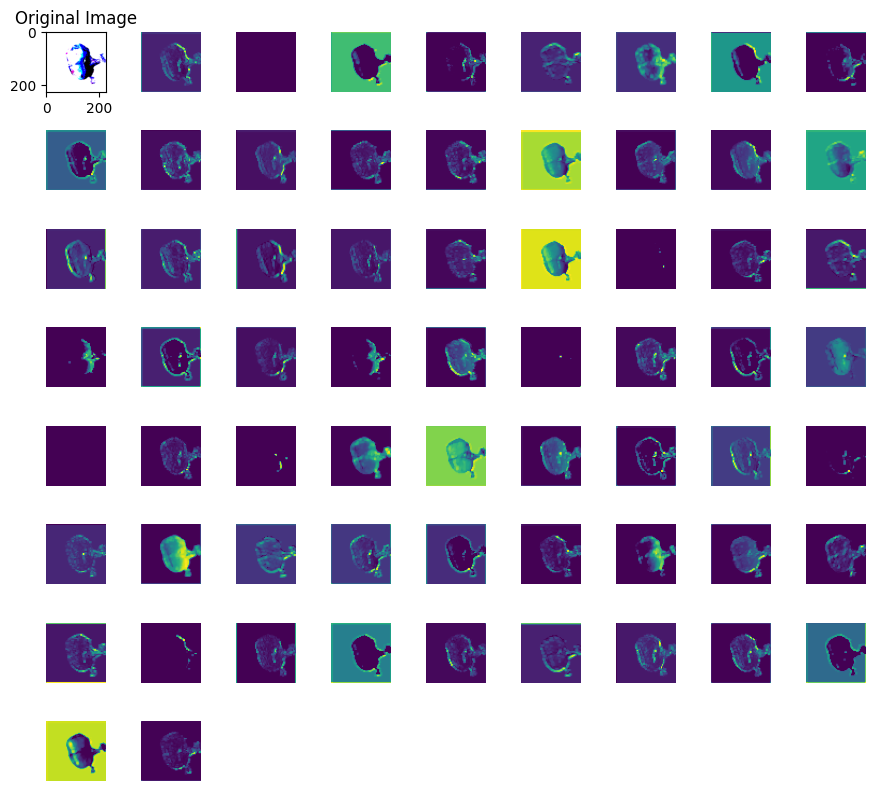

In [ ]:

layer_name = 'pool1_pool'
intermediate_layer_model = Model(inputs=resnet_model.input, outputs=resnet_model.get_layer(layer_name).output)

img_path = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg'
img = load_img(img_path, target_size=(224, 224))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

activations = intermediate_layer_model.predict(img_tensor)

# Number of features in the feature map
num_features = activations.shape[-1]

# Calculate the grid size needed to plot all feature maps and the original image
size = int(np.ceil(np.sqrt(num_features + 1)))  # +1 for the original image

# Plot original image
plt.figure(figsize=(size*1, size*1))
plt.subplot(size, size, 1)
plt.imshow(np.squeeze(img_tensor, axis=0))
plt.title('Original Image')

# Plot each channel in the feature map
for i in range(num_features):
    plt.subplot(size, size, i+2)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')

plt.tight_layout()
plt.show()

#**Code For Classification**

In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import os

# Initialize the base model
base_model = ResNet50(weights='imagenet', include_top=False)

def extract_features(model, layer_name, image_paths):
    model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    features = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        feature = model.predict(img_array)
        features.append(feature.flatten())
    return np.array(features)

# Example usage
image_paths = ['/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg', '/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 63.jpg']  # Add your image paths here
layer_name = 'conv5_block3_out'  # Example layer name

# Extract features
features = extract_features(base_model, layer_name, image_paths)

# Your labels (make sure to have the correct labels for your dataset)
labels = np.array([0, 1])  # Example binary labels

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a classifier
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


1/1 [==============================] - 0s 191ms/step


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0